#### Dataset Exploration


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt
from skimage.io import imread
from sklearn.model_selection import train_test_split
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K
from tensorflow.keras.losses import binary_crossentropy

# seaborn plot style
sns.set(style="darkgrid")


In [2]:
# Paths to data

TRAIN_CSV = r"C:\Ship Detection\train_ship_segmentations_v2.csv"
TRAIN_DIR = r"C:\Ship Detection\train_v2"
TEST_DIR = r"C:\Ship Detection\test_v2"

#### Dataset size

In [3]:
print("Number of images in train folder:", len(os.listdir(TRAIN_DIR)))
print("Number of images in test folder:", len(os.listdir(TEST_DIR)))

Number of images in train folder: 192556
Number of images in test folder: 15606


##### Ships distribution in images
The ground-truth segmentations are encoded in run-length format:

Each row defines the segmentation for a single ship
Images with n ships have n rows
Images without ships have one row with NaN as the value
The encoding format is a list of (start length) pairs in pixels

In [4]:
# Run length encoding CSV
rle_df = pd.read_csv(TRAIN_CSV)
rle_df.head()

ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

In [5]:
# Images with n ships have n rows
unique_rle_df = rle_df.drop_duplicates('ImageId')
num_images = len(unique_rle_df)
print("Number of images in run length encoding CSV:", num_images)

Number of images in run length encoding CSV: 192556


In [6]:
# Images without ships have EncodedPixels set to NaN
images_with_ships = unique_rle_df.dropna(subset=['EncodedPixels'])
num_images_with_ships = len(images_with_ships)
num_images_wo_ships = len(unique_rle_df) - len(images_with_ships)
print("Number of images with ships: {0} ({1:.1f}%)".format(num_images_with_ships, (num_images_with_ships / num_images) * 100))
print("Number of images without ships: {0} ({1:.1f}%)".format(num_images_wo_ships, (num_images_wo_ships / num_images) * 100))

Number of images with ships: 42556 (22.1%)
Number of images without ships: 150000 (77.9%)


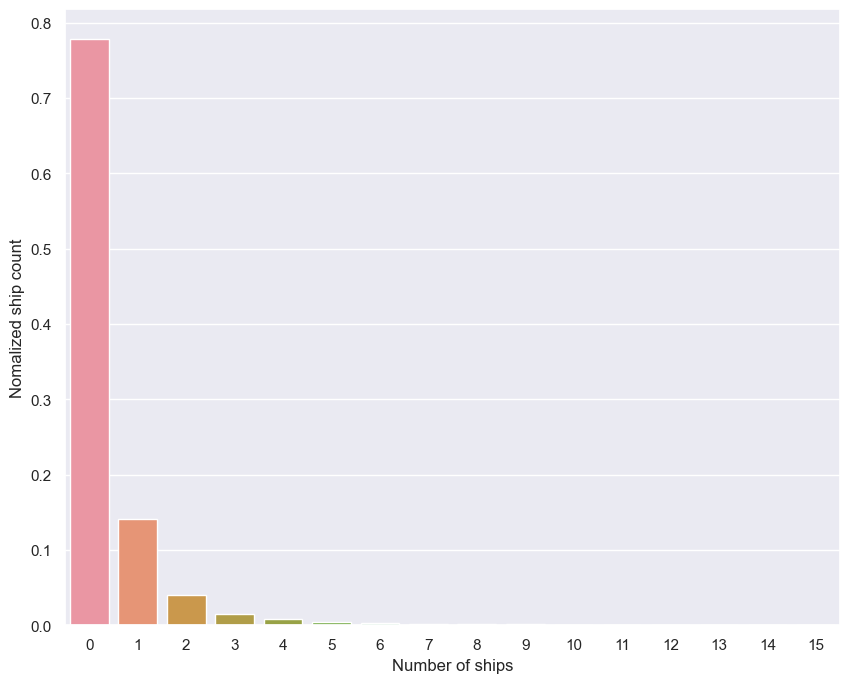

In [7]:
ship_count_df = rle_df.groupby('ImageId').count().reset_index().rename(columns={"EncodedPixels": "ShipCount"})
ship_dist = ship_count_df.groupby('ShipCount')['ShipCount'].agg('count')
ship_dist = ship_dist / sum(ship_dist)
fig = plt.figure(figsize=(10, 8))
g = sns.barplot(x=ship_dist.index, y=ship_dist.values)
_ = g.set_ylabel("Nomalized ship count")
_ = g.set_xlabel("Number of ships")

#### Ships distribution in pixels

In [8]:
def rle_pixel_count(rle):
    count = 0
    if not pd.isna(rle):
        rle_split = rle.split()
        for value in rle_split[1::2]:
            count += int(value)
    
    return count

rle_df['PixelCount'] = rle_df['EncodedPixels'].apply(rle_pixel_count)
total_ship_pixels = sum(rle_df['PixelCount'])
total_pixels = 768 * 768 * num_images
print("Percentage of ship-pixels: {0:.3f}%".format((total_ship_pixels / total_pixels) * 100))

Percentage of ship-pixels: 0.113%


In [9]:
total_pixels = 768 * 768 * num_images_with_ships
print("Percentage of ship-pixels: {0:.3f}%".format((total_ship_pixels / total_pixels) * 100))

Percentage of ship-pixels: 0.510%


#### Ship sizes

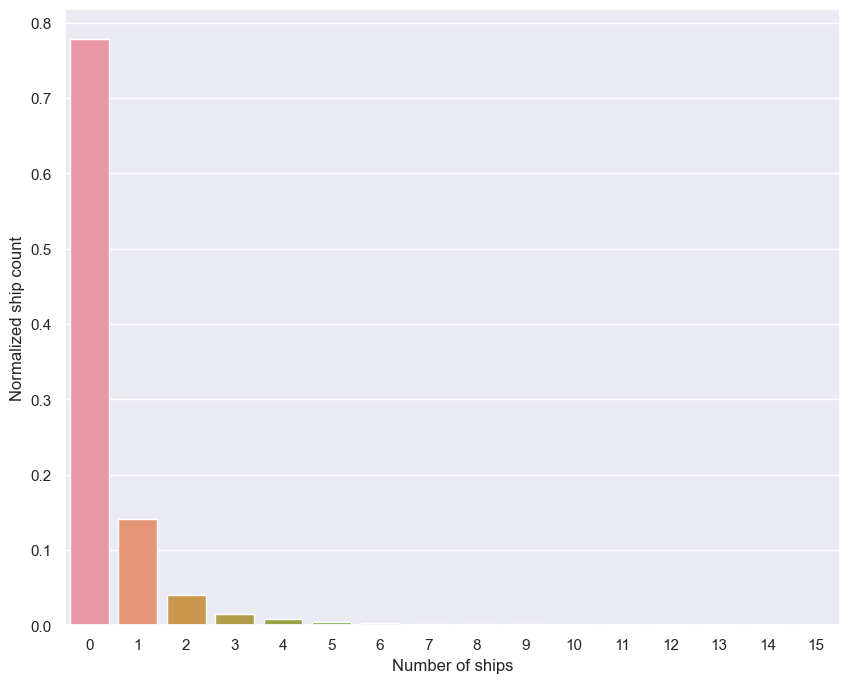

In [10]:
ship_count_df = rle_df.groupby('ImageId').count().reset_index().rename(columns={"EncodedPixels": "ShipCount"})
ship_dist = ship_count_df.groupby('ShipCount')['ShipCount'].agg('count')
ship_dist = ship_dist / sum(ship_dist)
fig = plt.figure(figsize=(10, 8))
g = sns.barplot(x=ship_dist.index, y=ship_dist.values)
g.set_ylabel("Normalized ship count")
g.set_xlabel("Number of ships")
plt.show()

In [11]:
min_size = 18
print("Number of ships with less than {} pixels: {}".format(min_size, len(ship_count_df.loc[ship_count_df['PixelCount'] < min_size])))

Number of ships with less than 18 pixels: 192556


Total number of images (original): 192556


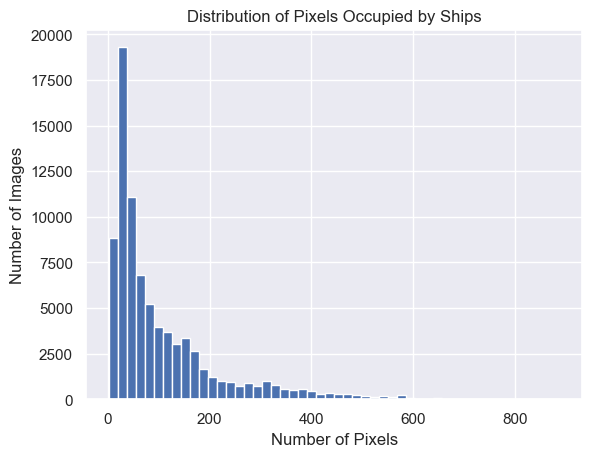

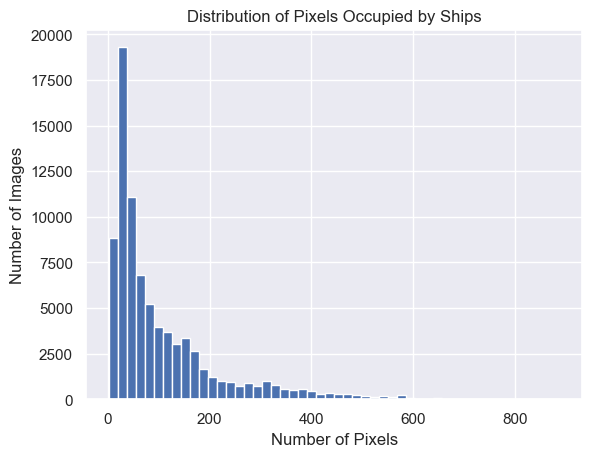

Total number of images (after removing corrupted images): 192555


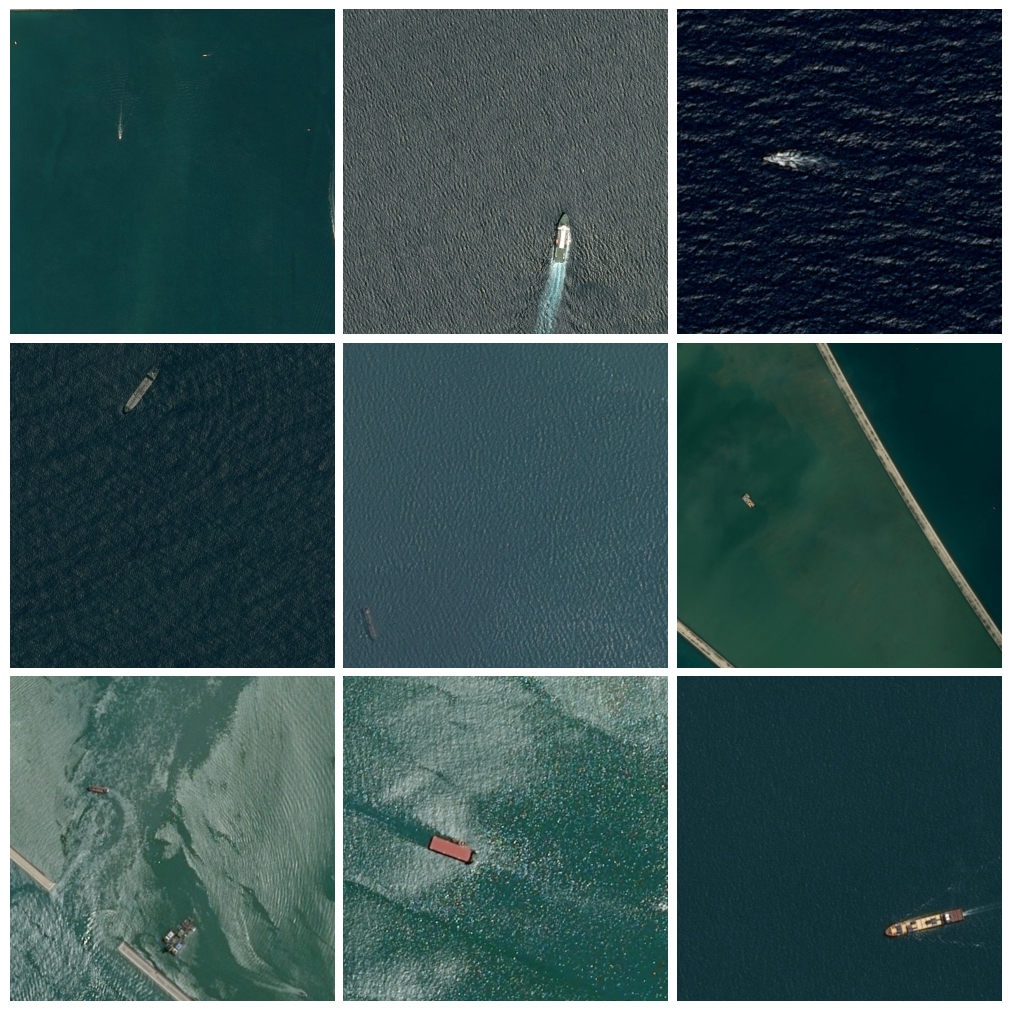

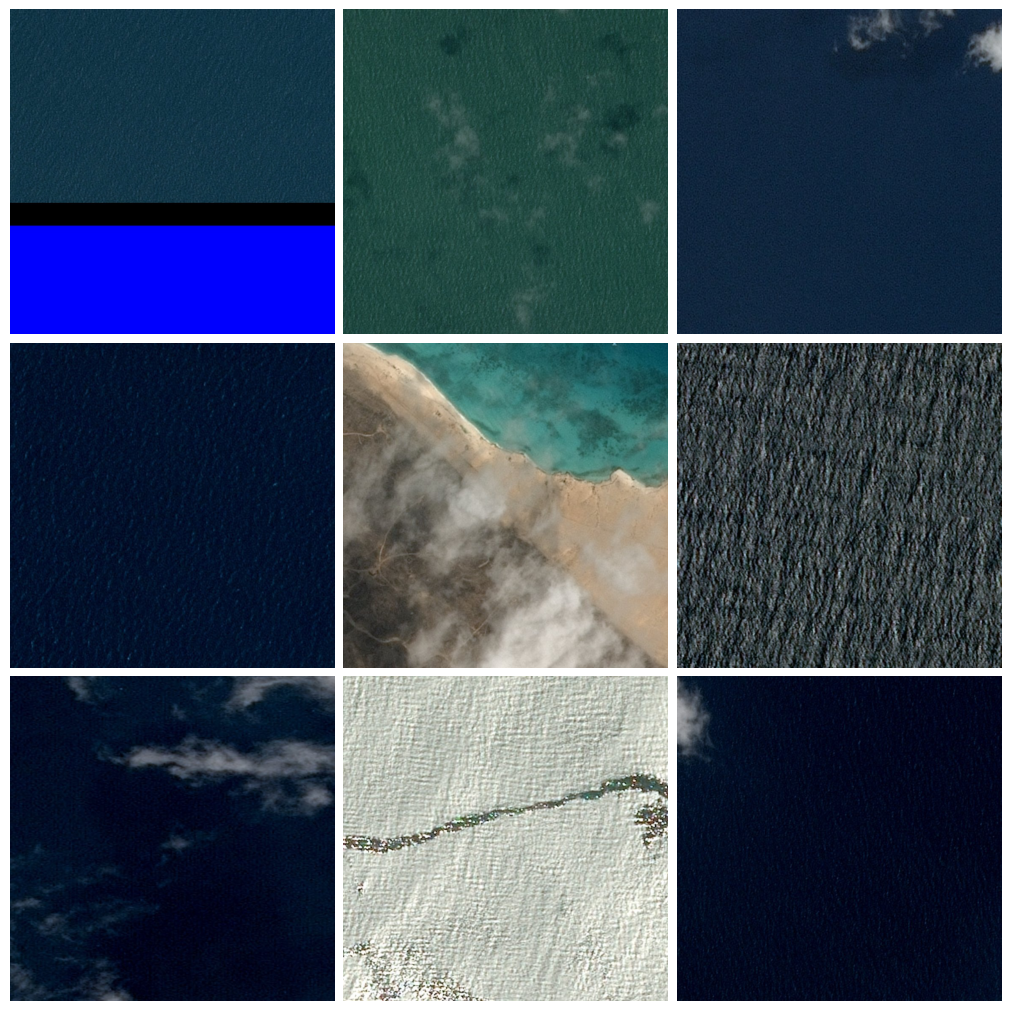

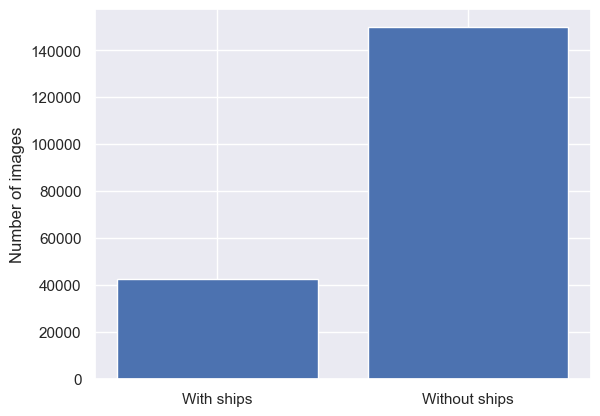

Number of images with ships : 42556 | Number of images without ships : 149999  (x3.5)


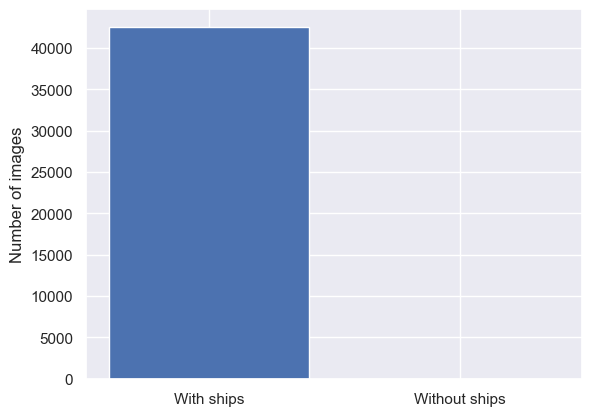

Number of images with ships : 42556 | Number of images without ships : 0  (x0.0)


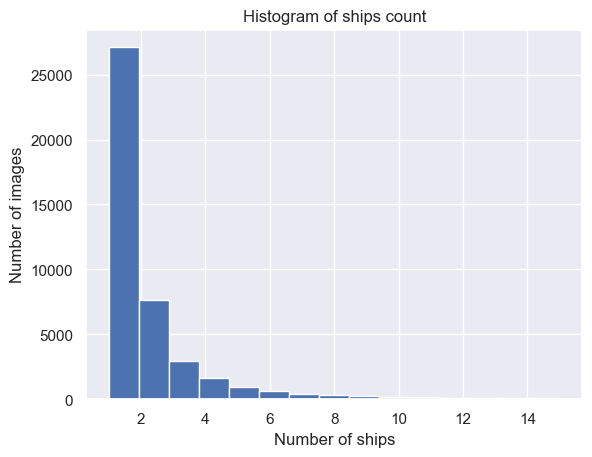

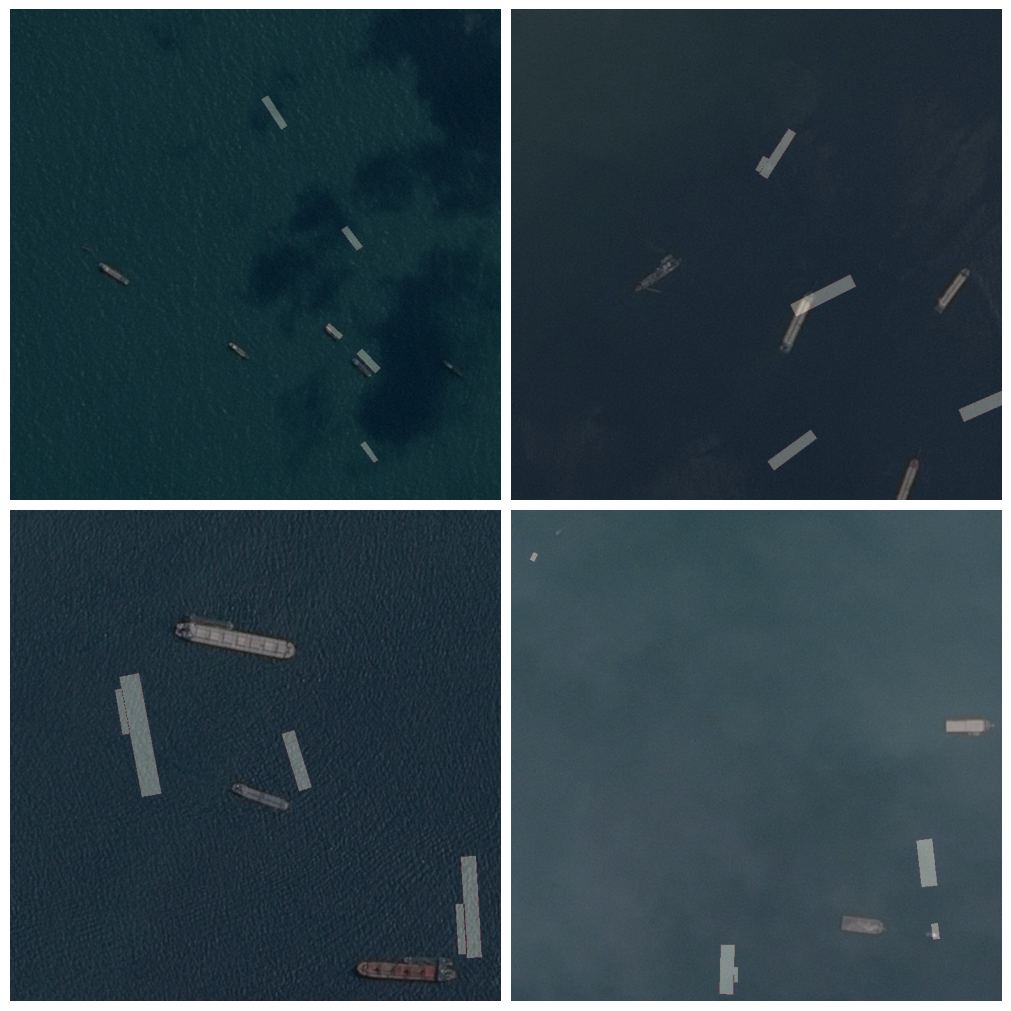

Number of training images : 40428


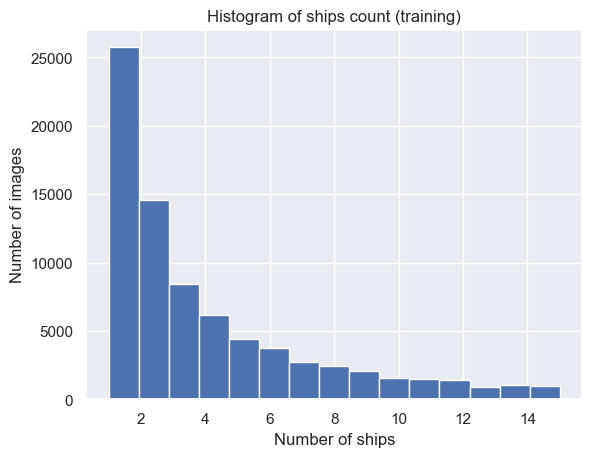

Number of validation images : 2128


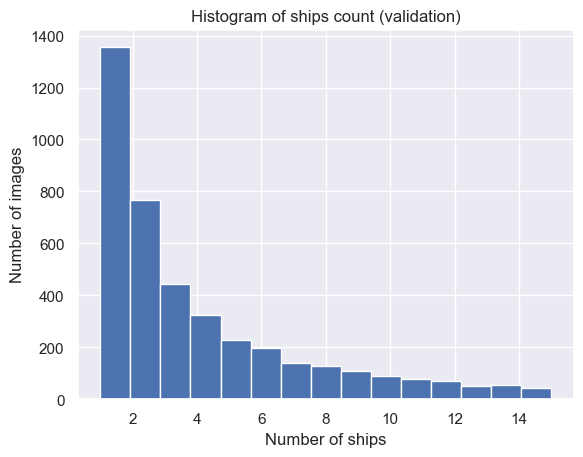

In [12]:

# Define rle_decode function
def rle_decode(rle_string, shape=(768, 768)):
    rle_numbers = list(map(int, rle_string.split()))
    mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for i in range(0, len(rle_numbers), 2):
        start = rle_numbers[i] - 1  # RLE is 1-indexed
        length = rle_numbers[i + 1]
        mask[start:start + length] = 1
    return mask.reshape(shape)

# Define show_pixels_distribution function
def show_pixels_distribution(masks):
    pixels = masks['EncodedPixels'].dropna().apply(lambda x: len(x.split()))
    plt.hist(pixels, bins=50)
    plt.title('Distribution of Pixels Occupied by Ships')
    plt.xlabel('Number of Pixels')
    plt.ylabel('Number of Images')
    plt.show()

# Read CSV as dataframe
masks = pd.read_csv(TRAIN_CSV)
print('Total number of images (original): %d' % masks['ImageId'].value_counts().shape[0])

# Show pixel distribution if set to True
SHOW_PIXELS_DIST = True  # Assuming this flag is set to True somewhere in your code
if SHOW_PIXELS_DIST:
    show_pixels_distribution(masks)
    show_pixels_distribution(masks.dropna())

# Remove corrupted image
masks = masks[~masks['ImageId'].isin(['6384c3e78.jpg'])]  # Remove corrupted file
unique_img_ids = masks.groupby('ImageId').size().reset_index(name='counts')
print('Total number of images (after removing corrupted images): %d' % masks['ImageId'].value_counts().shape[0])

# Plot images with ships
img_wships = masks[~masks['EncodedPixels'].isna()].sample(9)
fig, arr = plt.subplots(3, 3, figsize=(10, 10), constrained_layout=True)
for i, img in enumerate(img_wships['ImageId']):
    r = int(i / 3)
    c = i % 3
    arr[r, c].imshow(imread(os.path.join(TRAIN_DIR, img)))
    arr[r, c].axis('off')
plt.show()

# Plot images without ships
img_woships = masks[masks['EncodedPixels'].isna()].sample(9)
fig, arr = plt.subplots(3, 3, figsize=(10, 10), constrained_layout=True)
for i, img in enumerate(img_woships['ImageId']):
    r = int(i / 3)
    c = i % 3
    arr[r, c].imshow(imread(os.path.join(TRAIN_DIR, img)))
    arr[r, c].axis('off')
plt.show()

# Count number of ships per image
df_wships = masks.dropna()
df_wships = df_wships.groupby('ImageId').size().reset_index(name='counts')
df_woships = masks[masks['EncodedPixels'].isna()]

# Make a plot
plt.bar(['With ships', 'Without ships'], [len(df_wships), len(df_woships)])
plt.ylabel('Number of images')
plt.show()

print('Number of images with ships : %d | Number of images without ships : %d  (x%0.1f)' %
      (df_wships.shape[0], df_woships.shape[0], df_woships.shape[0] / df_wships.shape[0]))
## -> Unbalanced dataset

# Remove images without ships to help getting a more balanced dataset
masks = masks.dropna()
df_woships = masks[masks['EncodedPixels'].isna()]

# Make a plot
plt.bar(['With ships', 'Without ships'], [len(df_wships), len(df_woships)])
plt.ylabel('Number of images')
plt.show()

print('Number of images with ships : %d | Number of images without ships : %d  (x%0.1f)' %
      (df_wships.shape[0], df_woships.shape[0], df_woships.shape[0] / df_wships.shape[0]))
## -> Balanced dataset

# Plot histogram
hist = df_wships.hist(bins=df_wships['counts'].max())
plt.title("Histogram of ships count")
plt.xlabel("Number of ships")
plt.ylabel("Number of images")
plt.show(hist)

# Plot images with 5 ships
df_w5ships = df_wships.loc[df_wships['counts'] == 5]  # Change this to 5 ships
list_w5ships = df_w5ships.values.tolist()

fig, axarr = plt.subplots(2, 2, figsize=(10, 10), constrained_layout=True)
for i in range(4):
    rd_id = random.randrange(len(list_w5ships))
    img_masks = masks.loc[masks['ImageId'] == str(list_w5ships[rd_id][0]), 'EncodedPixels'].tolist()

    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768))  # Assuming the size is 768x768
    for mask in img_masks:
        all_masks += rle_decode(mask)
        
    r = int(i / 2)
    c = i % 2

    axarr[r][c].imshow(imread(os.path.join(TRAIN_DIR, list_w5ships[rd_id][0])))
    axarr[r][c].imshow(all_masks, alpha=0.3)
    axarr[r][c].axis('off')
                    
plt.show()

# Split dataset into training and validation sets
# stratify: same histograms of number of ships
unique_img_ids = masks.groupby('ImageId').size().reset_index(name='counts')

train_ids, val_ids = train_test_split(unique_img_ids, test_size=0.05, stratify=unique_img_ids['counts'], random_state=42)
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, val_ids)

train_df['counts'] = train_df.apply(lambda c_row: c_row['counts'] if isinstance(c_row['EncodedPixels'], str) else 0, axis=1)
valid_df['counts'] = valid_df.apply(lambda c_row: c_row['counts'] if isinstance(c_row['EncodedPixels'], str) else 0, axis=1)

print('Number of training images : %d' % train_df['ImageId'].value_counts().shape[0])
train_df['counts'].hist(bins=train_df['counts'].max())
plt.title("Histogram of ships count (training)")
plt.xlabel("Number of ships")
plt.ylabel("Number of images")
plt.show()

print('Number of validation images : %d' % valid_df['ImageId'].value_counts().shape[0])
valid_df['counts'].hist(bins=valid_df['counts'].max())
plt.title("Histogram of ships count (validation)")
plt.xlabel("Number of ships")
plt.ylabel("Number of images")
plt.show()


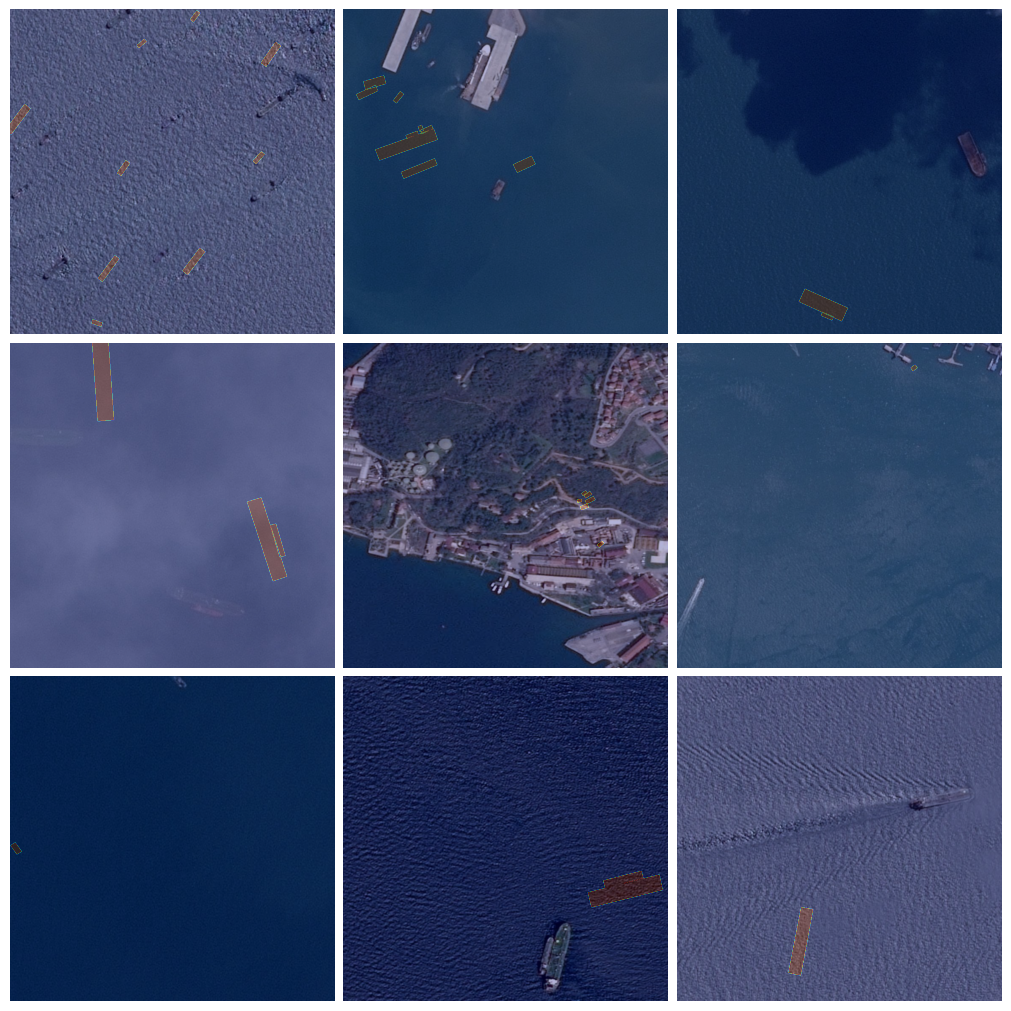

In [13]:
import matplotlib.pyplot as plt
from skimage.io import imread
import numpy as np
import random

# Define the rle_decode function
def rle_decode(rle_string, shape=(768, 768)):
    rle_numbers = list(map(int, rle_string.split()))
    mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for i in range(0, len(rle_numbers), 2):
        start = rle_numbers[i] - 1  # RLE is 1-indexed
        length = rle_numbers[i + 1]
        mask[start:start + length] = 1
    return mask.reshape(shape)

# Plot images with ships
img_wships = masks[~masks['EncodedPixels'].isna()].sample(9)  # Take 9 random images with ships
fig, arr = plt.subplots(3, 3, figsize=(10, 10), constrained_layout=True)

for i, img in enumerate(img_wships['ImageId']):
    r = int(i / 3)
    c = i % 3
    
    # Read the image
    img_path = os.path.join(TRAIN_DIR, img)
    img_data = imread(img_path)
    
    # Get the RLE masks for the current image
    img_masks = masks.loc[masks['ImageId'] == img, 'EncodedPixels'].dropna().tolist()
    
    # Create a mask for the current image (combine all ships in the image)
    combined_mask = np.zeros((768, 768))
    for mask in img_masks:
        combined_mask += rle_decode(mask)
    
    # Plot the image and overlay the mask
    arr[r, c].imshow(img_data)
    arr[r, c].imshow(combined_mask, alpha=0.3, cmap='jet')  # Overlay mask with 30% transparency
    arr[r, c].axis('off')

plt.show()


##### Make Dataset

In [14]:
BATCH_SIZE = 32

# downsampling in preprocessing
IMG_SCALING = (3, 3)

# number of validation images to use
VALID_IMG_COUNT = 900

# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 10
MAX_TRAIN_EPOCHS = 10

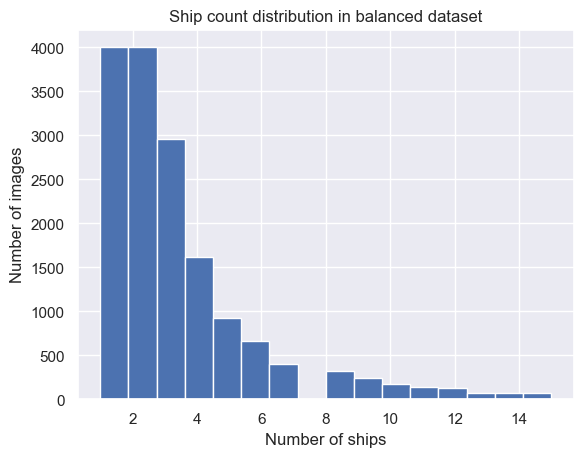

15778 masks


In [15]:
# Create the 'ships' column by counting the ships per image in rle_df
ship_counts = rle_df.groupby('ImageId')['EncodedPixels'].count().reset_index(name='ships')

# Now merge the counts back into unique_img_ids
unique_img_ids = unique_img_ids.merge(ship_counts, on='ImageId', how='left')

# Now you can proceed with the balancing and plotting
SAMPLES_PER_GROUP = 4000
balanced_train_df = unique_img_ids.groupby('ships').apply(lambda x: x.sample(SAMPLES_PER_GROUP) if len(x) > SAMPLES_PER_GROUP else x)

# Plot the histogram of ship counts in the balanced dataset
balanced_train_df['ships'].hist(bins=balanced_train_df['ships'].max() + 1)
plt.title('Ship count distribution in balanced dataset')
plt.xlabel('Number of ships')
plt.ylabel('Number of images')
plt.show()

# Print the number of masks in the balanced dataset
print(balanced_train_df.shape[0], 'masks')


####  Split train & validation set

In [16]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(balanced_train_df,
                 test_size = 0.2,
                 stratify = balanced_train_df['ships'])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

41012 training masks
10259 validation masks


#### Image generator


In [17]:
def rle_to_mask(rle_string, shape):
    """
    Converts a run-length encoding (RLE) string into a binary mask.
    Arguments:
        rle_string: RLE string
        shape: Shape of the mask (height, width)
    Returns:
        Binary mask
    """
    if rle_string is None:
        return np.zeros(shape, dtype=np.uint8)
    
    # Parse RLE
    try:
        rle_numbers = [int(num) for num in rle_string.split()]
        starts, lengths = rle_numbers[0::2], rle_numbers[1::2]
        starts = np.array(starts) - 1
        ends = starts + lengths
        mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)

        for start, end in zip(starts, ends):
            if start >= mask.size or end > mask.size:
                # Skip invalid RLEs without printing warnings
                continue
            mask[start:end] = 1
        return mask.reshape(shape).T
    except Exception:
        # Handle any parsing or indexing errors
        return np.zeros(shape, dtype=np.uint8)


In [18]:
def masks_as_image(in_mask_list, image_shape):
    """
    Combine RLEs into a single binary mask for the given shape.
    """
    all_masks = np.zeros(image_shape, dtype=np.uint8)
    for mask_string in in_mask_list:
        if mask_string:  # Check if RLE is not empty
            mask = rle_to_mask(mask_string, shape=image_shape[:2])
            all_masks = np.maximum(all_masks, mask)  # Combine masks
    return all_masks


In [19]:
def make_image_gen(in_df, batch_size=BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            try:
                # Load image
                rgb_path = os.path.join(TRAIN_DIR, c_img_id)
                c_img = imread(rgb_path)

                # Set image shape for mask generation
                image_shape = c_img.shape[:2]
                c_mask = np.expand_dims(
                    masks_as_image(c_masks['EncodedPixels'].values, image_shape),
                    -1
                )

                # Optional: Resize for consistency
                if IMG_SCALING is not None:
                    c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                    c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]

                out_rgb.append(c_img)
                out_mask.append(c_mask)

                # Yield batch if size is sufficient
                if len(out_rgb) >= batch_size:
                    yield np.stack(out_rgb, 0) / 255.0, np.stack(out_mask, 0).astype(np.float32)
                    out_rgb, out_mask = [], []
            except Exception as e:
                print(f"Error processing {c_img_id}: {e}")


In [20]:
train_gen = make_image_gen(train_df)
train_x, train_y = next(train_gen)
print(f"x {train_x.shape}, min {train_x.min()}, max {train_x.max()}")
print(f"y {train_y.shape}, min {train_y.min()}, max {train_y.max()}")


x (32, 256, 256, 3), min 0.0, max 1.0
y (32, 256, 256, 1), min 0.0, max 1.0


####  Make validatation set

In [21]:
valid_x, valid_y = next(make_image_gen(valid_df, VALID_IMG_COUNT))
print(valid_x.shape, valid_y.shape)

(900, 256, 256, 3) (900, 256, 256, 1)


#### Data Augmentation

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dg_args = dict(
                  rotation_range = 45,
                  width_shift_range = 0.1,
                  height_shift_range = 0.1,
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],
                  horizontal_flip = True,
                  vertical_flip = True,
                  fill_mode = 'reflect',
                  data_format = 'channels_last')

image_gen = ImageDataGenerator(**dg_args)
label_gen = ImageDataGenerator(**dg_args)


def create_aug_gen(in_gen, seed=None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))

    for in_x, in_y in in_gen:
        # Expand dimensions of masks to ensure they have 4D shape
        if in_y.ndim == 3:  # Check if masks are missing the channel dimension
            in_y = np.expand_dims(in_y, -1)
        
        seed = np.random.choice(range(9999))
        # Augment images
        g_x = image_gen.flow(in_x,
                             batch_size=in_x.shape[0],
                             seed=seed,
                             shuffle=True)
        # Augment masks
        g_y = label_gen.flow(in_y,
                             batch_size=in_x.shape[0],
                             seed=seed,
                             shuffle=True)

        yield next(g_x), next(g_y)


In [23]:
cur_gen = create_aug_gen(train_gen)
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())

x (32, 256, 256, 3) float32 0.0 1.0
y (32, 256, 256, 1) float32 0.0 1.0


#### Modeling

In [24]:
from tensorflow.keras import models, layers

# Build U-Net model
def unet(pretrained_weights = None, input_size = (256, 256, 3)):
    inputs = layers.Input(input_size)

    c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = layers.Dropout(0.2)(c4)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = layers.Dropout(0.3)(c5)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = layers.Dropout(0.2)(c6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis=3)
    c9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    d = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    seg_model = models.Model(inputs=[inputs], outputs=[d])

    seg_model.summary()
    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return seg_model

In [25]:
seg_model = unet()
seg_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 256, 256, 16)      │             448 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 256, 256, 16)      │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 256, 256, 16)      │           2,320 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 128, 128, 16)      │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 128, 128, 32)      │           4,640 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 128, 128, 32)      │               0 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 128, 128, 32)      │           9,248 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 64, 64, 32)        │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 64, 64, 64)        │          18,496 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 64, 64, 64)        │               0 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 64, 64, 64)        │          36,928 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 32, 32, 64)        │               0 │ conv2d_5[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 32, 32, 128)       │          73,856 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_3 (Dropout)           │ (None, 32, 32, 128)       │               0 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 32, 32, 128)       │         147,584 │ dropout_3[0][0]            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 256, 256, 16)      │             448 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 256, 256, 16)      │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 256, 256, 16)      │           2,320 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 128, 128, 16)      │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 128, 128, 32)      │           4,640 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 128, 128, 32)      │               0 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 128, 128, 32)      │           9,248 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 64, 64, 32)        │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 64, 64, 64)        │          18,496 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 64, 64, 64)        │               0 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 64, 64, 64)        │          36,928 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 32, 32, 64)        │               0 │ conv2d_5[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 32, 32, 128)       │          73,856 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_3 (Dropout)           │ (None, 32, 32, 128)       │               0 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 32, 32, 128)       │         147,584 │ dropout_3[0][0]            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

#### Loss Function

In [26]:
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

ALPHA = 0.8
GAMMA = 2

def FocalLoss(targets, inputs, alpha=ALPHA, gamma=GAMMA):

    inputs = K.flatten(inputs)
    targets = K.flatten(targets)

    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)

    return focal_loss

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

#### CallBack Setting

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

weight_path = "fullres_model & weights/seg_model_weights.best.weights.h5"

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1,
                             mode='max', save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.2,
                                   patience=3, verbose=1, mode='max', min_delta=0.0001,
                                   cooldown=2, min_lr=1e-6)

early = EarlyStopping(monitor="val_dice_coef", mode="max", patience=15)

callbacks_list = [checkpoint, early, reduceLROnPlat]


#### Compiling and Training the Model

In [ ]:
def fit():
    seg_model.compile(optimizer=Adam(1e-3), loss=FocalLoss, metrics=[dice_coef])

    step_count = min(MAX_TRAIN_STEPS, train_df.shape[0] // BATCH_SIZE)
    aug_gen = create_aug_gen(make_image_gen(train_df))  # Create the augmented generator

    # Correct usage of fit without 'workers' argument
    loss_history = seg_model.fit(
        aug_gen,
        steps_per_epoch=step_count,
        epochs=MAX_TRAIN_EPOCHS,
        validation_data=(valid_x, valid_y),
        callbacks=callbacks_list
    )

    return loss_history

# Call the fit function
loss_history = fit()


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - dice_coef: 0.0127 - loss: 0.1376
Epoch 1: saving model to fullres_model & weights/seg_model_weights.best.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 105s 10s/step - dice_coef: 0.0126 - loss: 0.1323 - val_dice_coef: 0.0071 - val_loss: 0.0182 - learning_rate: 0.0010
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - dice_coef: 0.0066 - loss: 0.0162
Epoch 2: saving model to fullres_model & weights/seg_model_weights.best.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 62s 6s/step - dice_coef: 0.0067 - loss: 0.0162 - val_dice_coef: 0.0095 - val_loss: 0.0164 - learning_rate: 0.0010
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - dice_coef: 0.0082 - loss: 0.0126
Epoch 3: saving model to fullres_model & weights/seg_model_weights.best.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 61s 6s/step - dice_coef: 0.0083 - loss: 0.0126 - val_dice_coef: 0.0112 - val_loss: 0.0136 - learning_rate: 0.0010
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - dice_coef: 0.0116 - los

#### Evaluate the Model

In [ ]:
# Evaluate the trained model on validation data
val_loss, val_dice = seg_model.evaluate(valid_x, valid_y, batch_size=BATCH_SIZE)
print(f"Validation Loss: {val_loss}")
print(f"Validation Dice Coefficient: {val_dice}")


#### Plot Training and Validation Loss/Accuracy

In [ ]:


# Assuming `history` contains the training history from `fit()`
# Plot training & validation loss
plt.plot(loss_history.history['loss'], label='Training Loss')
plt.plot(loss_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

# Plot training & validation Dice Coefficient
plt.plot(loss_history.history['dice_coef'], label='Training Dice Coefficient')
plt.plot(loss_history.history['val_dice_coef'], label='Validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.title('Training vs Validation Dice Coefficient')
plt.show()


####  Confusion matrix

In [ ]:
# Make predictions on the validation set
y_pred = seg_model.predict(valid_x)


In [ ]:
# Convert predictions and ground truth to binary (0 or 1)
y_pred_bin = (y_pred > 0.5).astype(np.uint8)  # Adjust threshold if needed
valid_y_bin = (valid_y > 0.5).astype(np.uint8)


In [ ]:
from sklearn.metrics import confusion_matrix

# Flatten the masks to calculate the confusion matrix
y_pred_flat = y_pred_bin.flatten()
valid_y_flat = valid_y_bin.flatten()

# Compute confusion matrix
cm = confusion_matrix(valid_y_flat, y_pred_flat)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)


In [ ]:
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Background", "Foreground"], yticklabels=["Background", "Foreground"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc

# Flatten the true and predicted labels
y_true = valid_y.flatten()
y_pred = y_pred.flatten()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve (ROC Curve)')
plt.legend(loc='lower right')
plt.show()


In [ ]:
from sklearn.metrics import precision_recall_curve

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

# Plot Precision-Recall curve
plt.figure(figsize=(6, 6))
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


In [ ]:
# Get the raw prediction for the selected index
y_pred_prob = seg_model.predict(valid_x[index:index+1])  # Predict for the selected index

# Visualize the raw probability output for the ship
plt.imshow(y_pred_prob[0, :, :, 0], cmap='jet')  # Visualize first channel if it's a single-channel mask
plt.title('Raw Predicted Probabilities')
plt.colorbar()
plt.show()


In [ ]:
loss_history = seg_model.fit(
    create_aug_gen(train_gen),  # Pass the training generator to the augmentation generator
    steps_per_epoch=MAX_TRAIN_STEPS,
    epochs=MAX_TRAIN_EPOCHS,
    validation_data=(valid_x, valid_y),
    callbacks=callbacks_list
)
